In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os


In [2]:
def generate_paths(compounds, condition, window, replicas,ftype):
    paths = []
    path_1 = '/home/arasouli/repos/alchemical/3_mg_rna_small_molecule_FE'
    if ftype == 'prmtop':
        path_3 = '1-sys_prep/box.prmtop'
    elif ftype == 'dcd':
        path_3 = '2-sim_run/equ_2/equ.0.dcd'

    for compound in compounds:
        for i in range(1, replicas + 1):
            path = os.path.join(path_1, compound, condition, window, f"{i}-rep{i}", path_3)
            paths.append(path)
    return paths



In [3]:
# List of DCD files for (55 mM NaCl + 2 Mg)
compounds = ['2-theophylline', '3-1_methylxanthine', '4-3_methylxanthine', '5-hypoxanthine', '6-xanthine', '7-caffeine']
dcds = generate_paths(compounds, '1-55NaCl_3Mg','1-40winCmplx_30winLig',3,'dcd')
prmtops = generate_paths(compounds, '1-55NaCl_3Mg', '1-40winCmplx_30winLig',3,'prmtop')

# Store the RDFs from each DCD
rdfs = []

for dcd, prmtop in zip(dcds, prmtops):
    # Load the DCD into a universe
    u = mda.Universe(prmtop,dcd)
    
    # Select the P and ion atoms
    phos = u.select_atoms("(nucleic or resname G5 C3) and name P")
    ions_sod = u.select_atoms("name Na+")
    
    # Set the bin size and maximum distance
    bin_size = 0.1
    max_distance = 15
    
    # Initialize the total RDF to zero
    total_rdf = np.zeros(int(max_distance/bin_size))
    
 
    # Loop over all frames in the trajectory
    for ts in u.trajectory[0::50]:
        # Calculate the RDF for the current frame and add it to the total
        rdf, edges = np.histogram(mda.lib.distances.distance_array(phos.positions,
                                                                   ions_sod.positions, 
                                                                   box=ts.dimensions[:6], 
                                                                   backend='OpenMP')
                                  ,bins=np.arange(0, max_distance+bin_size, bin_size),density=True)
        total_rdf += rdf
    
    # Average the total RDF over all frames
    avg_rdf = total_rdf / len(u.trajectory)
    rdfs.append(avg_rdf)
    
# Average the RDFs
avg_dcd_rdf = np.mean(rdfs, axis=0)



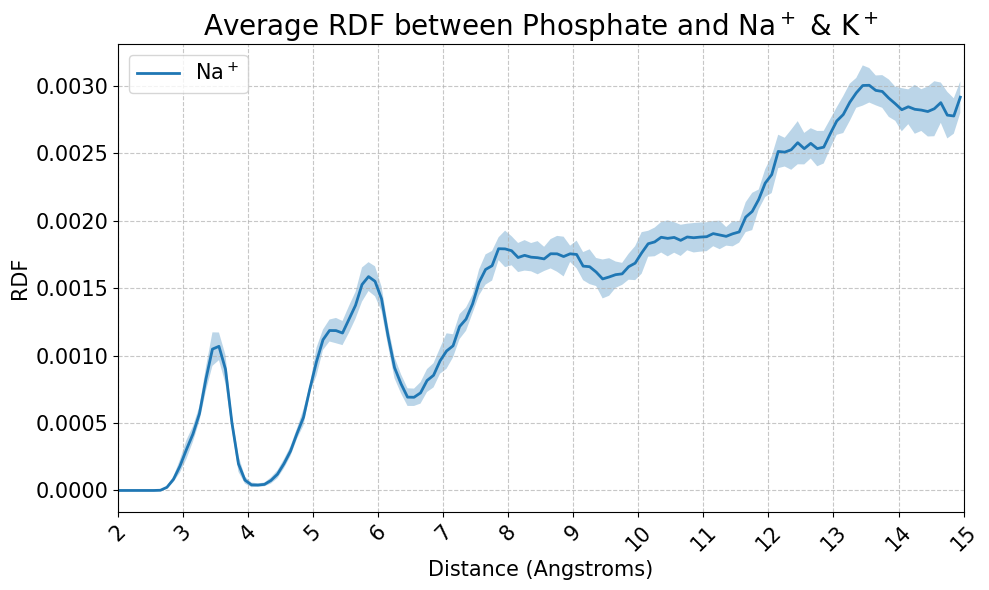

In [4]:
# Find the first peak in the RDF for Na
for i in range(1, len(avg_dcd_rdf) - 1):
    if avg_dcd_rdf[i] > avg_dcd_rdf[i-1] and avg_dcd_rdf[i] > avg_dcd_rdf[i+1]:
        peak = i
        break


        
# Plot the RDF and add a vertical line at the first peak
fig, ax = plt.subplots(figsize=(10, 6))
bin_centers = (edges[:-1] + edges[1:]) / 2
ax.plot(bin_centers, avg_dcd_rdf, label='Na$^+$', linewidth=2)
ax.fill_between(bin_centers, avg_dcd_rdf - np.std(rdfs, axis=0), avg_dcd_rdf + np.std(rdfs, axis=0), alpha=0.3)


# ax.axvline(edges[peak], color='red', linestyle='--', label='Peak Na')
# ax.axvline(edges[peak], color='pink', linestyle='--', label='Peak K')

# Add the x value of the first peak to the x ticks
# ax.set_xticks(np.append(ax.get_xticks(), edges[peak]))
# ax.set_xticks(np.append(ax.get_xticks(), edges[peak_K]))
# ax.set_xticklabels(rotation=45)
ax.set_xticks(np.arange(0, 16, 1))
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)

plt.xlim(2,15)
# Labels and title
ax.set_xlabel("Distance (Angstroms)", fontsize=15)
ax.set_ylabel("RDF", fontsize=15)
ax.set_title("Average RDF between Phosphate and Na$^+$ & K$^+$", fontsize=20)
# Legend
ax.legend(fontsize=15)

ax.xaxis.set_minor_locator(MultipleLocator(1))

# Grid and tight layout
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"./figs/RDF_Na_K.pdf", bbox_inches='tight')
plt.show()
